In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
%cd "/content/drive/MyDrive/CloneClown"
# %cd CloneClown
# drive.mount('/content/drive/MyDrive/CS282_final_project/CloneClown',force_remount=True)
%load_ext autoreload
%autoreload 2

Mounted at /content/drive
/content/drive/MyDrive/CloneClown


In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import utils
from BayesModel import BFC, FC

import cProfile
import pstats

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
train_loader, test_data = utils.get_nanotube_data(batch_size=200, scale=True, target_label="Calculated atomic")  # I have scaled data to have mean 0 and std 1 in all features.
# train_loader, test_data = utils.get_nanotube_data(test_size=0.95, batch_size=50, scale=True, target_label="Calculated atomic")  # I have scaled data to have mean 0 and std 1 in all features.
X_test, Y_test = test_data



In [14]:
def train_model(*, model, optimer, train, device, epochs, enums=10):
    # model.to(device)
    pbar = tqdm(range(epochs))
    losses = {"total": [], "recon": [], "kl": []}
    grads = {"absmean_0": [], "absmean_2": [], "absmean_4": [], "std_0": [], "std_2": [], "std_4": []}
    for epoch in pbar:
        for batch_idx, (x, y) in enumerate(train):
            # x, y = x.to(device), y.to(device)
            optimer.zero_grad()

            # sample batch enums times during training and average prediction before calculating loss
            outs = torch.zeros(enums, *y.size())
            for j in range(enums):
                outs[j] = model(x, train=True)
            
            pred = outs.mean(0)  # take average of all predictions of each datapoint as final prediction of that datapoint 
            loss_kl = model.kl_reset() / (len(train) * enums)  # normalise by number of batches and enums
            loss_recon = -torch.distributions.Normal(pred, 0.1).log_prob(y).mean()

            loss =  loss_recon + loss_kl
            loss.backward()
            for layer in [0, 2, 4]:
                model.layers[layer].weight_rho.grad
                model.layers[layer].weight_loc.grad

            optimer.step()
            for layer in [0, 2, 4]:
                grads[f"absmean_{layer}"].append(model.layers[layer].weight_loc.grad.abs().mean())
                grads[f"std_{layer}"].append(model.layers[layer].weight_loc.grad.std())
            
        pbar.set_description(f"total loss: {loss:.4f}, recon. loss: {loss_recon:.4f}, kl_loss: {loss_kl:.4f}")
        losses["total"].append(loss.detach().numpy())
        losses["recon"].append(loss_recon.detach().numpy())
        losses["kl"].append(loss_kl.detach().numpy())


    return losses, grads

def train_model_freq(*, model, optimer, train, device, epochs):
    pbar = tqdm(range(epochs))
    loss_fn = torch.nn.MSELoss()
    for epoch in pbar:
        for batch_idx, (x, y) in enumerate(train):
            x, y = x.to(device), y.to(device)
            optimer.zero_grad()

            # was simpler to copy code than generalize for non-kl_divergence shit
            pred = model(x.to(torch.float))
            loss = loss_fn(pred, y.to(torch.float))
            
            loss.backward()
            optimer.step()
        pbar.set_description(f"total loss: {loss:.4f}")

In [15]:
plt.rcParams["figure.figsize"] = (20,5)
def plot_model_pred(model, Y_test, X_test, enums=10, single=False):
    Y_sample = Y_test.detach().numpy()

    # sample test data enums times and average to make a prediction
    Y_pred = torch.zeros(enums, *Y_test.size())
    for j in range(enums):
        Y_pred[j] = model(X_test)

    if single:  # Plots all the predictions of a single data point
        y1 = Y_pred.detach().numpy()[:, 1]
        Y = Y_sample[1]
        pred_mean = y1.mean()
        x = np.linspace(0, 1, len(y1))
        plt.plot(x, y1, "bo", label="all preds for single datapoint")
        plt.plot(x, np.ones_like(x) * Y_sample[1], "r--", lw=5, label="true value")
        plt.plot(x, np.ones_like(x) * pred_mean, "k--", lw=4, label="prediction mean")
        plt.plot(x, pred_mean + np.ones_like(x) * y1.std(), "g--", lw=4, label="prediction std")
        plt.plot(x, pred_mean - np.ones_like(x) * y1.std(), "g--", lw=4)
        plt.xlabel("Prediction count")
        plt.ylabel("Value")
        plt.title("All predictions for a single datapoint after training")
    else:  # Plot mean of all predictions for 40 datapoints, with error bounds
        y1 = Y_pred.detach().numpy()
        pred_mean = y1.mean(0) 
        pred_std = y1.std(0)
        print("std mean: ", pred_std.mean())
        print("std std:", pred_std.std())
        x = np.arange(len(Y_sample))
        xx = np.c_[x, x, x, x, x, x] if Y_test.size(1) == 3 else np.c_[x, x]
        interval = np.c_[pred_mean - pred_std, pred_mean + pred_std]
        R2 = 1 - ((Y_sample - pred_mean) ** 2).sum() / ((Y_sample - Y_sample.mean()) ** 2).sum()
    
        plt.plot(Y_sample[:40], "bo", ms=8, label="target")
        plt.plot(pred_mean[:40], "ro", ms=4, label="mean")
        plt.plot(xx[:40], interval[:40], "go", ms=4, label="1 sigma")
        plt.title(f"R2: {R2}")
        plt.xlabel("Datapoints")
        plt.ylabel("Value")
    plt.legend()
    plt.show()

def plot_model_pred_freq(model, Y_test, X_test):
    Y_sample = Y_test.detach().numpy()
    Y_pred_sample = model(X_test.to(torch.float)).detach().numpy()

    R2 = 1 - ((Y_sample - Y_pred_sample) ** 2).sum() / ((Y_sample - Y_sample.mean()) ** 2).sum()
    # mse_err = ((Y_sample - Y_pred_sample) ** 2).mean()
    plt.plot(Y_sample[:100], "bo-", ms=8, label="target")
    plt.plot(Y_pred_sample[:100], "ro--", ms=4, label="prediction")
    plt.title(f"Total MSE on test data: {R2}")
    plt.legend()
    plt.show()

In [16]:
# use exactly same parameters for two models
net = BFC(features=5, classes=3, hiddens=[20, 20], prior={"dist": "vmf", "loc": 0, "scale": 0.5, "record": False, "dist_kwargs": {"k": 1}})
# net = BFC(features=5, classes=3, hiddens=[20, 20, 20, 20], prior={"dist": "normal", "loc": 0, "scale": 0.1, "record": True})
optimizer = torch.optim.AdamW(net.parameters(), lr=0.001)

fet = FC(features=5, classes=3, hiddens=[20, 20])
foptimizer = torch.optim.AdamW(fet.parameters(), lr=0.001)

/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:46: UserWarning: <class 'hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


  0%|          | 0/15 [00:00<?, ?it/s]

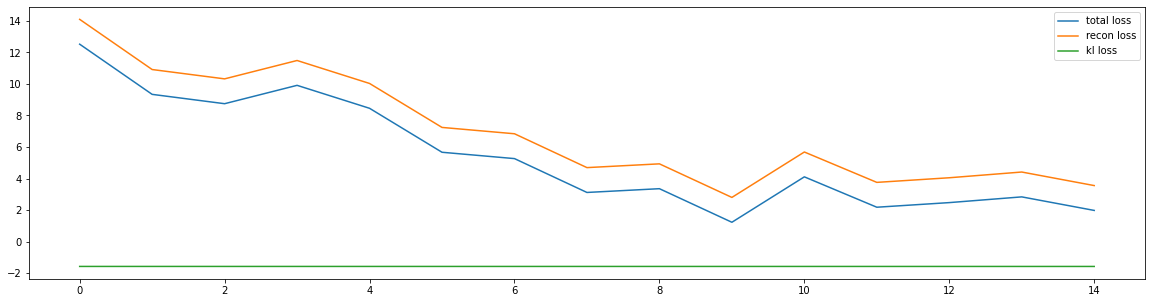

In [17]:
profiler = cProfile.Profile()
profiler.enable()
losses, grads = train_model(model=net, optimer=optimizer, train=train_loader, device=device, epochs=15, enums=10)
profiler.disable()

plt.plot(losses["total"][0:], label="total loss")
plt.plot(losses["recon"][0:], label="recon loss")
plt.plot(losses["kl"][0:], label="kl loss")
plt.legend()
plt.show()

In [ ]:
# profiler.print_stats(sort="cumtime")

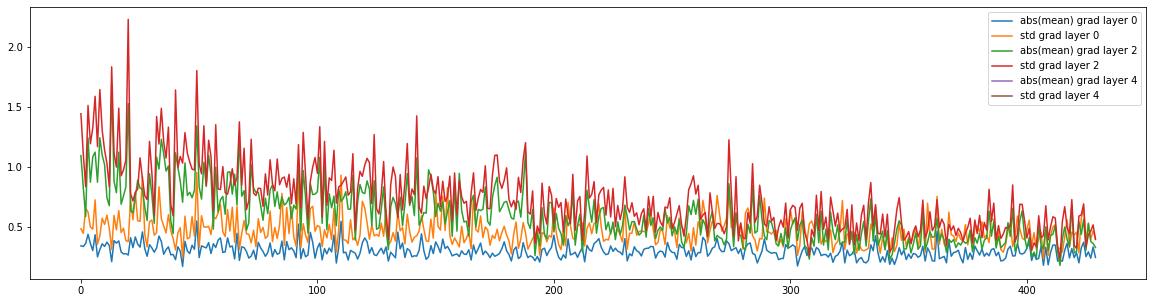

In [ ]:
for i in [0, 2, 4]:
    plt.plot(grads[f"absmean_{i}"], label=f"abs(mean) grad layer {i}")
    plt.plot(grads[f"std_{i}"], label=f"std grad layer {i}")
plt.legend()
plt.show()

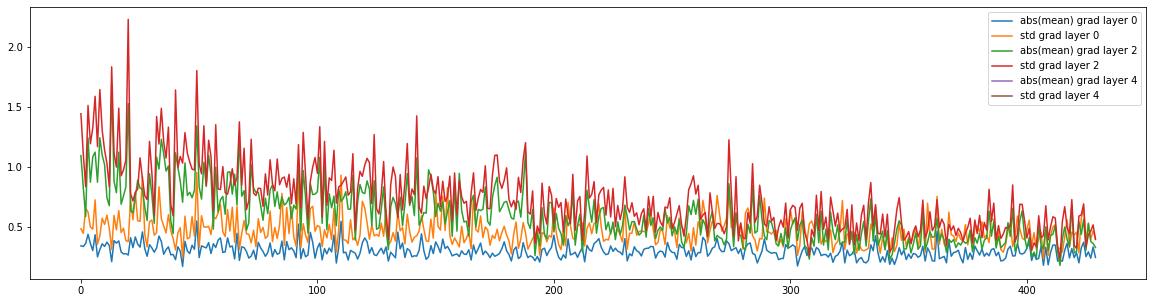

In [ ]:
for i in [0, 2, 4]:
    plt.plot(grads[f"absmean_{i}"], label=f"abs(mean) grad layer {i}")
    plt.plot(grads[f"std_{i}"], label=f"std grad layer {i}")
plt.legend()
plt.show()

std mean:  0.6436351
std std: 0.15364695


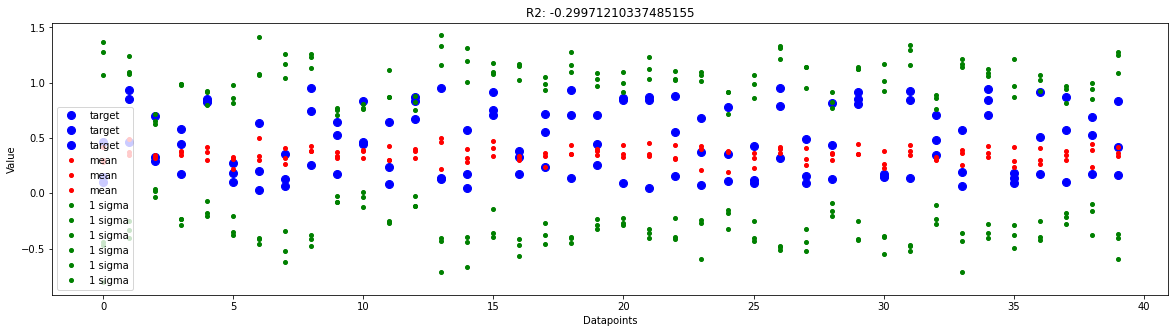

In [ ]:
plot_model_pred(net, Y_test, X_test, enums=100, single=False)

In [ ]:
for layer in net.layers:
    if hasattr(layer, "history"):
        plt.plot(layer.history["all"][1, 1])
plt.show()

TypeError: ignored

In [ ]:
train_model_freq(model=fet, optimer=foptimizer, train=train_loader, device=device, epochs=10)


In [ ]:
plot_model_pred_freq(fet, Y_test, X_test)
